In [25]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import torchaudio
import pickle

from tqdm import tqdm

import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import torchaudio

from tqdm import tqdm
from typing import Optional
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from mir_eval.separation import bss_eval_sources
from sklearn.model_selection import train_test_split



from enrollment_model import MyModel
# from load_data import BEATS_path, ORIG_mixture, ORIG_target #, stems
# from dataset import MusicDataset
from loss import L1SNR_Recons_Loss, L1SNRDecibelMatchLoss
from utils import _load_config
from metrics import (
    AverageMeter, cal_metrics, safe_signal_noise_ratio, MetricHandler
)

from models.types import InputType, OperationMode, SimpleishNamespace
from data.moisesdb.datamodule import (
    MoisesTestDataModule,
    MoisesValidationDataModule,
    MoisesDataModule,
    MoisesBalancedTrainDataModule,
    MoisesVDBODataModule,
)


from dismix.dismix_model import DisMixModel
from sklearn.manifold import TSNE

In [2]:
guitar_types = ['distorted_electric_guitar', 'clean_electric_guitar', 'acoustic_guitar']

# Load the JSON data
def load_json(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error decoding {file_path}.")
        return None

# Check for the presence of guitar types in the JSON data
def check_guitar_types(data, guitar_types):
    found_guitars = {guitar: [] for guitar in guitar_types}

    # Traverse stems and tracks
    if 'stems' in data:
        for stem in data['stems']:
            if 'tracks' in stem:
                for track in stem['tracks']:
                    track_type = track.get('trackType', '')
                    if track_type in guitar_types:
                        found_guitars[track_type].append(track.get('id', ''))

    return found_guitars

search_path = '/home/buffett/NAS_NTU/moisesdb/moisesdb_v0.1'
target_list = []
result_list = []

for song in tqdm(os.listdir(search_path)):
    data_json = os.path.join(search_path, song, 'data.json')
    data = load_json(data_json)
    
    if data:
        result = check_guitar_types(data, guitar_types)
        found = False

        for g in guitar_types:
            if len(result[g]) != 0:
                found = True
        
        if found:
            target_list.append(data_json.split('data.json')[0])
            result_list.append(result)
    

100%|██████████| 240/240 [00:02<00:00, 104.85it/s]


In [3]:
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

# Cropping
def crop_sustain_phase(mel_spectrogram, crop_frames=10, start_frame=None):
    """
    Crop a 320ms segment (10 frames) from the sustain phase of the mel spectrogram.
    
    Parameters:
    - mel_spectrogram: Mel spectrogram to crop.
    - crop_frames: Number of frames to crop (10 frames corresponds to 320ms).
    - start_frame: Starting frame for cropping (if None, find from sustain phase).
    
    Returns:
    - Cropped mel spectrogram segment, start_frame used for alignment.
    """
    # Calculate energy for each frame
    frame_energy = torch.sum(mel_spectrogram, dim=0)
    
    # Find the maximum energy frame index (attack phase) if start_frame is not provided
    if start_frame is None:
        max_energy_frame = torch.argmax(frame_energy)
        # Define the starting frame of the sustain phase, a few frames after the peak energy
        start_frame = max_energy_frame + 5  # Shift 5 frames after peak to avoid attack phase
    
    # Ensure the crop window does not exceed the spectrogram length
    if start_frame + crop_frames > mel_spectrogram.size(1):
        start_frame = max(0, mel_spectrogram.size(1) - crop_frames)
    
    # Crop the mel spectrogram segment
    cropped_segment = mel_spectrogram[:, start_frame:start_frame + crop_frames]
    
    return cropped_segment, start_frame



def processing(waveform, start_frame=None):
    
    mel_spectrogram = mel_spectrogram_transform(waveform)
    
    # Convert amplitude to decibel scale
    mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel_spectrogram)
    
    # Crop a 320ms segment (10 frames) from the sustain phase
    cropped_mel_spectrogram, start_frame = crop_sustain_phase(mel_spectrogram_db.squeeze(0), crop_frames=10, start_frame=start_frame)
    
    return cropped_mel_spectrogram, start_frame

In [4]:
path_list = []
stem_list = []
for t, r in zip(target_list, result_list):
    for g in guitar_types:
        if len(r[g]) != 0:
            for gid in r[g]:
                
                path = os.path.join(t, "guitar", f"{gid}.wav")
                if os.path.exists(path):
                    path_list.append(path)
                    stem_list.append(g)

len(path_list), len(stem_list)

(436, 436)

In [5]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

model = DisMixModel(
    input_dim=128, 
    latent_dim=64, 
    hidden_dim=256, 
    gru_hidden_dim=256,
    num_frames=10,
    pitch_classes=52,
    output_dim=128,    
).to(device)

model.load_state_dict(torch.load('dismix/best_model.pth', weights_only=False))

<All keys matched successfully>

In [ ]:
pitch_store = []
timbre_store = []
stem_store = []
               
for p, s in tqdm(zip(path_list, stem_list)):

    q_wav, _ = torchaudio.load(p)
    q_wav = q_wav.mean(dim=0)
    query, start_frame = processing(q_wav)
    
    mix_path = os.path.join(p.replace('moisesdb_v0.1', 'npy2').split('guitar/')[0], 'mixture.npy')
    mix_np = np.load(mix_path)
    mix_torch = torch.from_numpy(mix_np).mean(dim=0)
    mixture, _ = processing(mix_torch, start_frame)
    
    query = torch.unsqueeze(query, dim=0).to(device)
    mixture = torch.unsqueeze(mixture, dim=0).to(device)

    rec_mixture, pitch_latent, pitch_logits, timbre_latent, timbre_mean, timbre_logvar, eq = model(mixture, query)
    
    pitch_store.append(pitch_latent)
    timbre_store.append(timbre_latent)
    stem_store.append(s)


with open('pitch_store.pkl', 'wb') as f:
    pickle.dump(pitch_store, f)
with open('timbre_store.pkl', 'wb') as f:
    pickle.dump(timbre_store, f)
with open('stem_store.pkl', 'wb') as f:
    pickle.dump(stem_store, f)

In [12]:
with open('pitch_store.pkl', 'rb') as f:
    pitch_store = pickle.load(f)
with open('timbre_store.pkl', 'rb') as f:
    timbre_store = pickle.load(f)
with open('stem_store.pkl', 'rb') as f:
    stem_store = pickle.load(f)

In [16]:
for i in range(len(timbre_store)):
    timbre_store[i] = timbre_store[i].cpu().detach().numpy()

In [17]:
timbre_store = np.stack(timbre_store).squeeze(axis=1)
timbre_store.shape

(436, 64)

In [20]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)

tsne_data = tsne.fit_transform(timbre_store)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 436 samples in 0.001s...
[t-SNE] Computed neighbors for 436 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 436 / 436
[t-SNE] Mean sigma: 2.507979
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.697006
[t-SNE] KL divergence after 1000 iterations: 1.971240


In [23]:
tsne_data = pd.concat([pd.DataFrame(tsne_data, columns=["x", "y"]), pd.Series(stem_store, name="stem")], axis=1)

<Axes: xlabel='x', ylabel='y'>

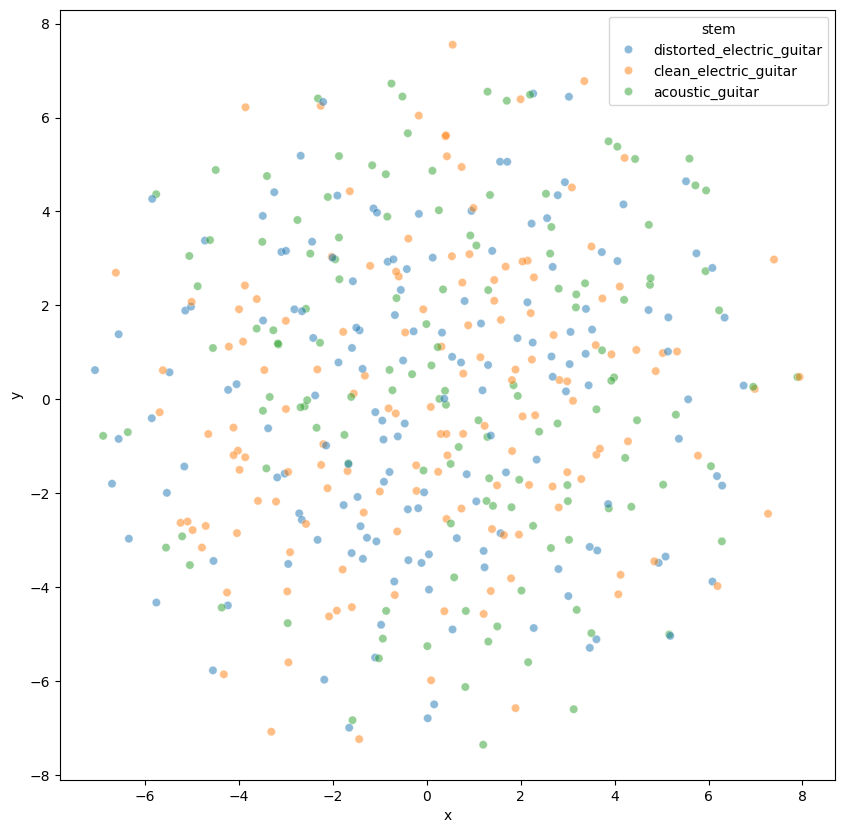

In [26]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_data, x="x", y="y", hue="stem", alpha=0.5)